In [1]:
import pandas as pd
import cptac
import statistics as st
import cptac.utils as ut
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
#import transform_pval 
from scipy import stats
import scipy

In [2]:
correlation_df = pd.read_csv('data (old)/TP53_trans_effects.csv')
correlation_df = correlation_df[correlation_df.cancer == 'luad']

In [3]:
correlation_df[correlation_df.gene =='A2M']

,Unnamed: 0,gene,mutated_correlation,non_mutated_correlation,non_mutated_p_vals,mutated_p_vals,delta_correlation,delta_correlation_pval,cancer
19018,1,A2M,0.346003,0.384392,0.005354,0.007268,-0.038389,0.821782,luad


In [4]:
sig_correlation_change_df = correlation_df[correlation_df.delta_correlation_pval <= 0.05 / len(correlation_df)]

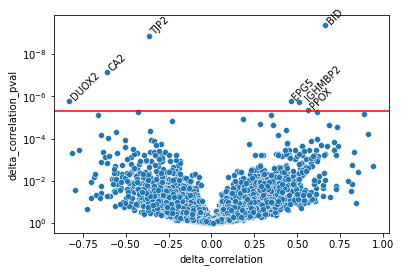

In [5]:
g = sns.scatterplot(data = correlation_df, x = 'delta_correlation', y = 'delta_correlation_pval')
g.invert_yaxis()
g.set_yscale('log')
for x,y,z in zip(sig_correlation_change_df['delta_correlation'], sig_correlation_change_df['delta_correlation_pval'], sig_correlation_change_df['gene']):    
    if 'BP2' in z:
        x *= 1.05
    plt.text(x = x, y = y * .9, s = z, color = 'black', rotation = 45)
plt.axhline(y = 0.05 / len(correlation_df), color = 'r')


In [6]:
def get_omics_df(cancer, mutated_gene):
    transcriptomics_df = cancer.get_transcriptomics(tissue_type='tumor')
    proteomics_df = cancer.get_proteomics(tissue_type='tumor')
    if isinstance(proteomics_df.columns, pd.MultiIndex):
        proteomics_df = proteomics_df.droplevel('Database_ID', axis = 1)
    if isinstance(transcriptomics_df.columns, pd.MultiIndex):
        transcriptomics_df = transcriptomics_df.droplevel('Database_ID', axis = 1)
    proteomics_df['patient_ID'] = proteomics_df.index
    transcriptomics_df['patient_ID'] = transcriptomics_df.index
    transcriptomics_df = transcriptomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='transcriptomics')
    proteomics_df = proteomics_df.melt(id_vars='patient_ID', var_name = 'gene', value_name='proteomics')
    mutation_df = cancer.get_somatic_mutation()
    mutation_df = mutation_df[mutation_df.Gene == mutated_gene]
    omics_df = pd.merge(transcriptomics_df, proteomics_df, how = 'inner')
    omics_df['mutation_status'] = omics_df.patient_ID.isin(mutation_df.index)
    omics_df = omics_df.dropna()
    return omics_df

In [7]:
luad = cptac.Luad()
cancer_dict = {luad: 'luad'}

In [8]:
omics_df = get_omics_df(luad, 'TP53')
omics_df

,patient_ID,gene,transcriptomics,proteomics,mutation_status
0,C3L-00001,A1BG,2.2545,-2.5347,False
1,C3L-00009,A1BG,1.4770,-0.5627,True
2,C3L-00080,A1BG,1.5103,-1.9422,True
3,C3L-00083,A1BG,3.0398,2.1636,False
4,C3L-00093,A1BG,1.7528,-1.0022,True
...,...,...,...,...,...
1149605,C3N-02729,ZZZ3,3.7482,-0.9491,False
1149606,X11LU013,ZZZ3,3.9118,-0.8214,True
1149607,X11LU016,ZZZ3,4.2600,0.3780,True
1149608,X11LU022,ZZZ3,4.3142,0.5894,True


In [9]:
sig_omics_df = omics_df[omics_df.gene.isin(sig_correlation_change_df.gene)]

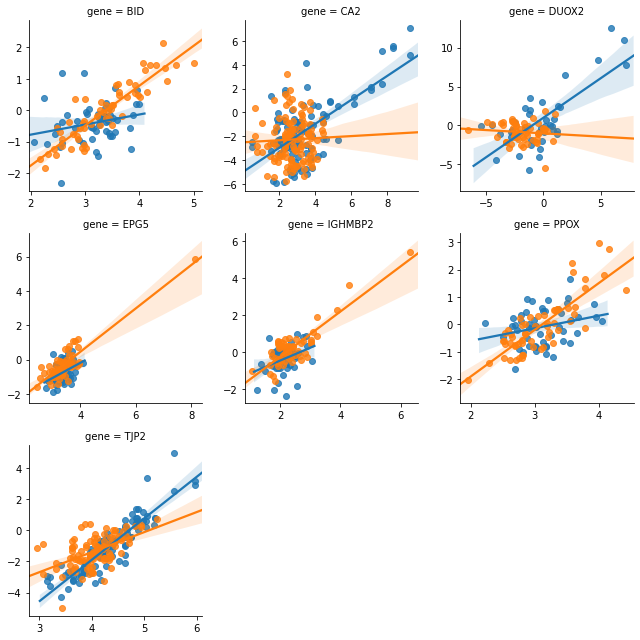

In [10]:
g = sns.FacetGrid(data = sig_omics_df, col = 'gene', hue = 'mutation_status', sharex = False, sharey = False, col_wrap = 3)
g.map_dataframe(sns.regplot, x = 'transcriptomics', y = 'proteomics', fit_reg = True, truncate = False)

In [11]:
df1 = sig_correlation_change_df.melt(value_vars = ['non_mutated_correlation', 'mutated_correlation'], var_name = 'mutation_status', value_name = 'correlation', id_vars = ['gene', 'cancer']).replace(['non_mutated_correlation', 'mutated_correlation'], ['wt', 'mutated'])
df2 = sig_correlation_change_df.melt(value_vars = ['mutated_p_vals', 'non_mutated_p_vals'], value_name = 'p-val',var_name = 'mutation_status', id_vars = ['gene', 'cancer']).replace(['mutated_p_vals', 'non_mutated_p_vals'], ['mutated', 'wt'])
df = pd.merge(df1, df2)
df['significant_correlation'] = df['p-val'] < 0.05 / len(correlation_df)

Text(0.5, 1.0, 'TP53 Mutation Effects')

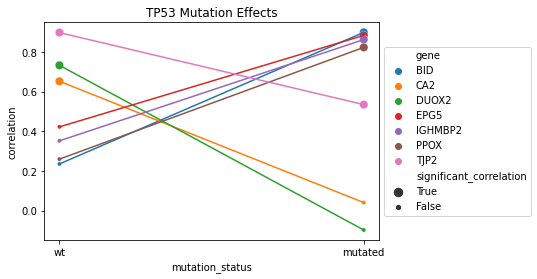

In [12]:
fig, ax = plt.subplots()
sns.lineplot(data = df, x = 'mutation_status', y = 'correlation', hue = 'gene', legend = False)
sns.scatterplot(data = df , x = 'mutation_status', y = 'correlation', hue = 'gene', size = 'significant_correlation', size_order = [True, False])
ax.legend(loc = 'center left', bbox_to_anchor=(1, 0.5))
ax.set_title('{col_name}')
plt.title('TP53 Mutation Effects')